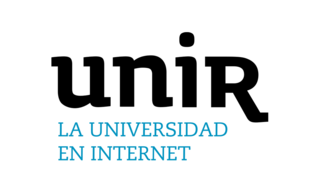

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [ ]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


## **Fase 2: Diseño e Implementación del Modelo Transformer**



## **NUEVO CICLO DE ENTRENAMIENTO+FINE-TUNING DESPUES DE REDUCIR A 7 CLASES (MEJOR MODELO HASTA AHORA) Y REFORZAR DATASET CON ERRORES DE CLASIFICACION (YSO)**

Último ciclo de pruebas: después de llegar al mejor modelo en `astro_transformer_fase2_sagemaker.ipynb`, se analizaron los errores de clasificación del modelo y se vio que la clase YSO, aun siendo ahora la mayoritaria en el dataset, generaba muchos falsos positivos (clase predicha YSO pero otra clase real) y también un buen número de falsos negativos (otras clases que el modelo confundía y predecía como YSO). 

En el notebook `16_preprocesado_YSO_review.ipynb` se generaron los datasets con IDs de objeto, así como CSVs de errores de clasificación, también con IDs de objeto. Cruzando todo ello se concluyó:

- 🔍 Total de FALSOS NEGATIVOS (YSO reales pero no predichas): **430**
- 🔍 Total de FALSOS POSITIVOS (YSO predichas pero no reales): **858**
- 🔍 Total de curvas a eliminar: 1288

Motivo_descarte
YSO predicha incorrectamente (FP)    858
YSO mal clasificada (FN)             430

📊 **Curvas confusas**. Desglose por clase original (impacto en dataset):

| Clase                | Nº curvas |
| -------------------- | --------- |
| Young Stellar Object | 430     |
| Eclipsing Binary     | 238     |
| Cataclysmic          | 195     |
| Rotational           | 170     |
| Delta Scuti          | 101     |
| RR Lyrae             | 97     |
| Irregular            | 57     |

✅ Guardado en: ../data/train/curvas_a_eliminar_por_confusion_yso.csv

La idea es hacer un nuevo preprocesado + training + fine tuning, en el que los datasets se van a generar nuevos pero filtrando las clases de manera que se eliminen las curvas identificadas como dudosas o confusas: 

- 📂 [INFO] IDs a excluir por filtrado: 1288
- 📂 [INFO] Exclusiones por clase: {'Cataclysmic': 195, 'Delta Scuti': 97, 'Eclipsing Binary': 238, 'Irregular': 57, 'RR Lyrae': 101, 'Rotational': 170, 'Young Stellar Object': 430}

#### 1. **PREPROCESADO**

In [1]:
import warnings
import numpy as np
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

# Ignorar solo los RuntimeWarning de numpy (como overflows en reduce)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

from src.fase2.script_1_transformer_preprocessing_optimizado_2 import main as preprocessing_optimized_YSO_cleaning

# Balanceo de clases 
max_per_class_override={
    "Irregular": 9000,
    "Rotational": 9000,
    "Eclipsing Binary": 9000,
    "Delta Scuti": None,            # 7.550 → TODAS
    "RR Lyrae": 9000,               # 41.208 → RECORTAMOS A 9.000
    "Young Stellar Object": None,   # 9.809 → TODAS 
    "Cataclysmic": None,            # 2.080 → TODAS
    "White Dwarf": 0,               # 0 → LA ELIMINAMOS
    "Variable": 0                   # 0 → LA ELIMINAMOS
}

# El script se ha adaptado para filtrar curvas malas directamente con el parametro `filtrar_curvas_malas`
preprocessing_optimized_YSO_cleaning(
    seq_length=25000,
    max_per_class=None, # usamos override completo
    max_per_class_override=max_per_class_override,
    parquet_batch_size=10_000_000,
    dataloader_batch_size=128,
    num_workers=20,
    filtrar_curvas_malas="../data/train/curvas_a_eliminar_por_confusion_yso.csv"
    #errores_csv_path=Path("../outputs/errores_mal_clasificados.csv")
)

📂 Cargando datos en lotes con PyArrow...
📂 [INFO] IDs a excluir por filtrado: 1288
📂 [INFO] Exclusiones por clase: {'Cataclysmic': 195, 'Delta Scuti': 97, 'Eclipsing Binary': 238, 'Irregular': 57, 'RR Lyrae': 101, 'Rotational': 170, 'Young Stellar Object': 430}
⏳ [INFO] Iniciando agrupación de curvas por objeto...


Agrupando curvas por objeto: 63batch [11:40, 11.13s/batch]

⏳ [INFO] Agrupación finalizada en 11 minutos y 41.1 segundos
📈 [INFO] Total de objetos agrupados: 54947


💾 [INFO] Agrupación guardada en cache: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../data/train/grouped_data.pkl
⏳ [INFO] Tiempo en agrupación de datos: 711.0 segundos
🚀 Procesando 54947 curvas en paralelo usando 20 CPUs...
⏳ [INFO] Tiempo en procesamiento paralelo: 70.4 segundos
🔋 [INFO] Curvas válidas tras filtrado: 54854

🔍 Realizando prueba rápida en características auxiliares...
✅ Sample 0 sin problemas: [-0.45523393 -0.37867646 -0.50204082 -0.08531    -0.38367345 -0.32518611
  0.00972491]
✅ Sample 1 sin problemas: [-0.31823412 -0.18750002 -0.30285714 -0.19434042 -0.17142858 -0.25113119
 -0.2245436 ]
✅ Sample 2 sin problemas: [-0.12917623  0.0073529  -0.24979591 -0.28714091  0.0163265  -0.19634882
 -0.28047611]
✅ Sample 3 sin problemas: [-0.41481858 -0.38511031 -0.31020408  0.02621751 -0.39591838  1.1180529
  2.24228415]
✅ Sample 4 sin problemas: [-0.41962832 -0.34558824 -0.48734694 -0.14689959 -0.34285713 -0.22032859
 -0.20701263]
✅ Sample 5 sin problemas: [ 0.775660

(<torch.utils.data.dataloader.DataLoader at 0x7f7201ee8df0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7201ee8700>)


#### Nueva distribución de clases tras preprocesado:


| Cod. | Clase                | Nº curvas |
| ---- | -------------------- | --------- |
| 0    | Cataclysmic          | **2.027**     |
| 1    | Delta Scuti          | **7.279**     |
| 2    | Eclipsing Binary     | **9.000**     |
| 3    | Irregular            | **9.000**     |
| 4    | RR Lyrae             | **9.000**     |
| 5    | Rotational           | **9.000**     |
| 6    | Young Stellar Object | **9.548**    |
|      | TOTAL                | **54.854** |

**Verificaciones...**

In [2]:
# Ejemplo para comprobar el contenido de un dataset .pt
import torch
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
    
# Cargar el dataset (ajusta la ruta si es necesario)
dataset = torch.load("../data/train/train_dataset.pt", weights_only=False)

# Obtener el primer elemento
sample = dataset[0]

# Mostrar información de cada campo
for i, value in enumerate(sample):
    print(f"Elemento {i}: tipo={type(value)}, valor/shape={getattr(value, 'shape', value)}")

# Ejemplo de salida esperada:
# Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=tensor(3)
# Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
# Elemento 4: tipo=<class 'str'>, valor/shape=ASASSN-V J055358.70+014409.5

Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([])
Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
Elemento 4: tipo=<class 'str'>, valor/shape=630280


In [7]:
import pandas as pd

# Cargar ambos archivos
df_errores = pd.read_csv("../outputs/todos_los_errores.csv")
df_ref = pd.read_csv("../data/train/debug_clases_codificadas.csv")

# Renombrar para evitar conflictos
df_ref = df_ref.rename(columns={"id": "id_objeto", "clase_variable": "clase_real_ref"})

# ⚠️ Filtrar solo errores cuyos IDs aún están en el dataset final
df_errores_filtrados = df_errores[df_errores["id_objeto"].isin(df_ref["id_objeto"])].copy()

# Cruzar por ID
df_merge = pd.merge(df_errores_filtrados, df_ref, on="id_objeto", how="left")

# Verificar discrepancias REALES
df_discrepancias = df_merge[df_merge["clase_real"] != df_merge["clase_real_ref"]]

# Mostrar resumen
print(f"🔎 Total errores analizados: {len(df_errores_filtrados)} (de {len(df_errores)} totales)")
print(f"❌ Discrepancias reales: {len(df_discrepancias)}")
if not df_discrepancias.empty:
    print(df_discrepancias.head(10))


🔎 Total errores analizados: 1032 (de 2323 totales)
❌ Discrepancias reales: 862
                      id_objeto        clase_real    clase_predicha  \
0  ASASSN-V J024305.65-065501.3  Eclipsing Binary       Delta Scuti   
1  ASASSN-V J031438.40+581303.1       Delta Scuti          RR Lyrae   
2  ASASSN-V J093207.60-823329.8        Rotational         Irregular   
3  ASASSN-V J114016.78+184126.4  Eclipsing Binary       Delta Scuti   
4                        459672          RR Lyrae  Eclipsing Binary   
5  ASASSN-V J002142.23-414002.5         Irregular        Rotational   
6  ASASSN-V J112416.67-110645.0         Irregular        Rotational   
7  ASASSN-V J032732.09+000351.4        Rotational         Irregular   
8  ASASSN-V J030537.58-593637.3       Cataclysmic          RR Lyrae   
9                    AP43491782       Cataclysmic          RR Lyrae   

     clase_real_ref  clase_codificada  
0       Delta Scuti                 1  
1         Irregular                 3  
2       Cataclysmic

In [10]:
import torch

# Cargar dataset
val_dataset = torch.load("../data/train/train_dataset.pt", weights_only=False)

# Elegir IDs concretos con discrepancias
ids_problema = [
    "ASASSN-V J024305.65-065501.3",
    "ASASSN-V J031438.40+581303.1",
    "ASASSN-V J093207.60-823329.8",
    "ASASSN-V J114016.78+184126.4",
    "459672",
    "ASASSN-V J002142.23-414002.5",
    "ASASSN-V J112416.67-110645.0",
    "ASASSN-V J032732.09+000351.4",
    "ASASSN-V J030537.58-593637.3",
    "AP43491782"
]

# Cargar CSV codificado
df_codificadas = pd.read_csv("../data/train/debug_clases_codificadas.csv")
df_codificadas = df_codificadas.set_index("id")

# Cargar encoder
import pickle
with open("../data/train/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
inv_label_encoder = {v: k for k, v in label_encoder.items()}

# Buscar en val_dataset los objetos y verificar su label real
print("🔍 Verificación directa en dataset:")
for i in range(len(val_dataset)):
    _, label, _, _, id_obj = val_dataset[i]
    if id_obj in ids_problema:
        clase_real_dataset = inv_label_encoder[label.item()]
        clase_codificada_csv = df_codificadas.loc[id_obj, "clase_codificada"]
        clase_nombre_csv = df_codificadas.loc[id_obj, "clase_variable"]
        print(f"🧾 ID: {id_obj}")
        print(f" - Clase val_dataset: {clase_real_dataset}")
        print(f" - Clase CSV codificado: {clase_nombre_csv} ({clase_codificada_csv})")
        print("---")


🔍 Verificación directa en val_dataset:
🧾 ID: ASASSN-V J112416.67-110645.0
 - Clase val_dataset: Eclipsing Binary
 - Clase CSV codificado: Eclipsing Binary (2)
---
🧾 ID: ASASSN-V J114016.78+184126.4
 - Clase val_dataset: RR Lyrae
 - Clase CSV codificado: RR Lyrae (4)
---
🧾 ID: ASASSN-V J024305.65-065501.3
 - Clase val_dataset: Delta Scuti
 - Clase CSV codificado: Delta Scuti (1)
---
🧾 ID: 459672
 - Clase val_dataset: Irregular
 - Clase CSV codificado: Irregular (3)
---
🧾 ID: ASASSN-V J093207.60-823329.8
 - Clase val_dataset: Cataclysmic
 - Clase CSV codificado: Cataclysmic (0)
---
🧾 ID: AP43491782
 - Clase val_dataset: Rotational
 - Clase CSV codificado: Rotational (5)
---
🧾 ID: ASASSN-V J030537.58-593637.3
 - Clase val_dataset: RR Lyrae
 - Clase CSV codificado: RR Lyrae (4)
---


#### 2. **ENTRENAMIENTO**

In [ ]:
import sys
import torch
import pickle
from torch.utils.data import DataLoader
from pathlib import Path
import time
import os
import gc

gc.collect()
torch.cuda.empty_cache()
# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_training_optimizado2 import main as train_model_optimized2

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🔄 Restaurando datasets...")
start = time.time()
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")
print(f"✅ Dataset cargado en {time.time() - start:.2f} segundos")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=10, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

######################################################################
# Crear un mini-dataloader con batch pequeño para inspección
batch_size = 256
debug_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for i, (x, y, mask, features, ids) in enumerate(debug_loader):
    if i >= 100:
        break
    # Validaciones de tipo
    if not torch.is_tensor(x) or not torch.is_tensor(mask):
        print(f"❌ No tensor en entrada en batch {i}")
    if not torch.is_tensor(y) or not torch.is_tensor(features):
        print(f"❌ y o features no son tensores en batch {i}")
    # Validaciones de contenido
    if not torch.isfinite(x).all():
        print(f"⚠️ x contiene NaN o Inf en batch {i}")
    if not torch.isfinite(mask).all():
        print(f"⚠️ mask contiene NaN o Inf en batch {i}")
    if not torch.isfinite(features).all():
        print(f"⚠️ features contiene NaN o Inf en batch {i}:\n{features}")
    # Validación de forma
    if features.shape[1] != 7:
        print(f"❌ Tamaño inesperado en features en batch {i}: {features.shape}")
    if x.shape != mask.shape:
        print(f"❌ Tamaños incompatibles en batch {i}: x {x.shape}, mask {mask.shape}")
    # Validación de etiquetas
    for j, label in enumerate(y):
        if not isinstance(label.item(), int):
            print(f"❌ Etiqueta no entera en batch {i}, elemento {j}: {label}")
        if label.item() < 0 or label.item() >= 9:
            print(f"❌ Etiqueta fuera de rango en batch {i}, elemento {j}: {label.item()}")
print("✅ Comprobación completada")
######################################################################

# Calcular número de clases
label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"TOTAL CLASES: {num_classes}")

# Ejecutar entrenamiento optimizado: 
# Ponderación por clase con class_weight
# dropout=0.3
# Scheduler ReduceLROnPlateau
# Early stopping
# Curvas de pérdida y accuracy
print("🚀 Entrenando modelo optimizado...")
model = train_model_optimized2(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=50,
    lr=3e-5,
    freeze_encoder=True,  # transfer learning clásico
    patience=6,           # early stopping
    debug=False           # True para depuración
)

#### 3. **FINE TUNING 1/2**

In [ ]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning optimizado
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# label_smoothing=0.1 para mejorar la generalización (lo hemos quitado en esta prueba)
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=40,
    patience=5,
    # freeze_encoder=False,
    freeze_epochs=2,
    encoder_lr=3e-6,
    head_lr=1e-4,  # Para acelerar la adaptación de la capa final
    gamma=3
)

#### 4. **FINE TUNING 2/2**

In [ ]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=12, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=12, pin_memory=True,persistent_workers=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning adicional
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# Usar scheduler ReduceLROnPlateau
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="mejor_modelo_finetuned_optimizado2.pt",
    label_encoder=label_encoder,
    device=device,
    epochs=15,
    patience=5,
    freeze_encoder=False,
    #freeze_epochs=2,
    encoder_lr=2e-6,
    head_lr=5e-6,
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)